In [102]:
%matplotlib inline
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [103]:
df = pd.read_csv('../dataset/subtitles_dataset_tokenized.csv')
crew_df = pd.read_csv('../dataset/crew.tsv', sep='\t')

In [104]:
df = pd.read_csv('../dataset/subtitles_dataset_tokenized.csv')
crew_df = pd.read_csv('../dataset/crew.tsv', sep='\t')

In [105]:
# merge datasets
crew_df['IMDB_ID'] = crew_df.tconst.apply(lambda x: int(x.replace('tt', '')))
df = df.merge(right=crew_df, on='IMDB_ID', how='outer')
#df = df.drop(['directors_x', 'writers_x', 'directors_y', 'writers_y'], axis=1)
df = df.drop('tconst', axis=1)
df = df.replace(r'\N', np.nan)

In [107]:
df.set_index('filename', inplace=True)
df.dropna(inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

In [119]:
df.drop_duplicates(subset='IMDB_ID', inplace=True)

In [120]:
df['main_genre'] = df.genre.str.split(',').apply(lambda x: x[0])

In [121]:
df.head()

,text,IMDB_ID,genre,year,production_region,corpus,duration,directors,writers,main_genre
filename,,,,,,,,,,
6581015.xml,HINTER DER LEIWAND Die Anwendung für die Arbei...,6414,"Comedy,Romance,Short",1916.0,English,untokenisiert,30,nm0000122,"nm0117018,nm0000122,nm1176713",Comedy
6564964.xml,DER GRAF Maße : Hals 30 cm - Ohr - 4 cm Mounth...,6548,"Comedy,Short",1916.0,English,untokenisiert,24,nm0000122,"nm0117018,nm0000122,nm1176713",Comedy
6412883.xml,"Chaplin bei der Feuerwehr "" Lass doch das Haus...",6684,"Comedy,Short",1916.0,English,untokenisiert,24,nm0000122,"nm0000122,nm0117018,nm1176713",Comedy
6565009.xml,Der Abenteurer Der Mann Jagd . Ein morgendlich...,7613,"Comedy,Short",1917.0,English,untokenisiert,24,nm0000122,"nm0117018,nm0000122,nm1176713",Comedy
6564950.xml,Die Heilquelle Die Gesundheit Frühling La moll...,7832,"Comedy,Short",1917.0,English,untokenisiert,24,nm0000122,"nm0117018,nm0000122,nm1176713",Comedy


In [122]:
df.shape

(11304, 10)

In [ ]:
for text in df.sample(4).text:
    print(f"{text[:len(text)//10]}\n\n")

### Ideen für Features:
* POS-Tags auszählen
* (Länge der Sätze)
* Textlänge (?!)
* Anzahl Stopwörter
* Varianz von WordEmbeddings eines Textes
* Varianz der TFI-IDF Werte
* Anzahl Sonderzeichen (nicht gut)
* Anzahl Fragezeichen/ Ausrufezeichen / einzelene Punkte / dreifache Punkte
* Atmo- und Geräuschbreschreibungen in Klammern => (Schüssse) etc.

In [49]:
import spacy
import re
import numpy as np
from sklearn.base import TransformerMixin
from typing import Iterable, List
from tqdm import tqdm

class POSTransformer(TransformerMixin):
    
    def __init__(self, spacy_model: str ='de_core_news_sm', verbose: bool = False, *args, **kwargs):
        self.spacy_model = spacy_model
        self.verbose = verbose 
        super().__init__(*args, **kwargs)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: Iterable[str],  y=None):
        pos_tags = set()
        nlp = spacy.load(self.spacy_model)
        Xt = []
        X = tqdm(X) if self.verbose else X
        for x in X:
            doc = nlp(x)
            Xt.append(" ".join([token.pos_ for token in doc]))
        self.tags__ = list(pos_tags)
        return Xt

class SentenceMarkCounter(TransformerMixin):
    
    def __init__(self,
                 marks: List[str] = None,
                 normalize: bool = True,
                 verbose: bool = False,
                 *args,
                 **kwargs):
        self.marks = marks if marks else [r'\.', r'\?', r'!', r'\.{3}']
        self.verbose = verbose
        self.normalize = normalize
        super().__init__(*args, **kwargs)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        Xt = []
        X = tqdm(X) if self.verbose else X
        for x in X:
            xt = np.array([len(re.findall(mark, x)) for mark in self.marks])
            if self.normalize:
                xt = xt / len(x)
            Xt.append(xt)
        return np.asarray(Xt)        

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer

transformer = SentenceMarkCounter(verbose=True)
Xmarks = transformer.fit_transform(df.text)

100%|██████████| 18277/18277 [00:11<00:00, 1593.37it/s]


In [9]:
df_marks = pd.DataFrame.from_records(
    Xmarks,
    columns=['n_dots', 'n_questionmarks', 'n_explanationmarks', 'n_ellipsis']
)
df_marks['filename'] = df.index
df_marks.set_index('filename', inplace=True)
df_marks.head()

,n_dots,n_questionmarks,n_explanationmarks,n_ellipsis
filename,,,,
6581015.xml,0.011905,0.006494,0.014069,0.0
6564964.xml,0.007491,0.000000,0.011236,0.0
6412883.xml,0.015306,0.000000,0.000000,0.0
6565009.xml,0.018476,0.000000,0.011547,0.0
6564950.xml,0.000000,0.000000,0.022409,0.0


In [10]:
assert df.shape[0] == df_marks.shape[0]
new_df = pd.concat([df, df_marks], axis=1)
new_df['n_characters'] = [len(re.sub('\s+', '', text)) for text in new_df.text]
new_df['duration'] = [int(re.findall(r'\d+', entry)[0])  for entry in new_df['duration']]
new_df.head()

,text,IMDB_ID,genre,year,production_region,corpus,duration,n_dots,n_questionmarks,n_explanationmarks,n_ellipsis,n_characters
filename,,,,,,,,,,,,
6581015.xml,HINTER DER LEIWAND Die Anwendung für die Arbei...,6414,"Comedy,Romance,Short",1916,English,untokenisiert,30,0.011905,0.006494,0.014069,0.0,735
6564964.xml,DER GRAF Maße : Hals 30 cm - Ohr - 4 cm Mounth...,6548,"Comedy,Short",1916,English,untokenisiert,24,0.007491,0.000000,0.011236,0.0,422
6412883.xml,"Chaplin bei der Feuerwehr "" Lass doch das Haus...",6684,"Comedy,Short",1916,English,untokenisiert,24,0.015306,0.000000,0.000000,0.0,159
6565009.xml,Der Abenteurer Der Mann Jagd . Ein morgendlich...,7613,"Comedy,Short",1917,English,untokenisiert,24,0.018476,0.000000,0.011547,0.0,348
6564950.xml,Die Heilquelle Die Gesundheit Frühling La moll...,7832,"Comedy,Short",1917,English,untokenisiert,24,0.000000,0.000000,0.022409,0.0,284


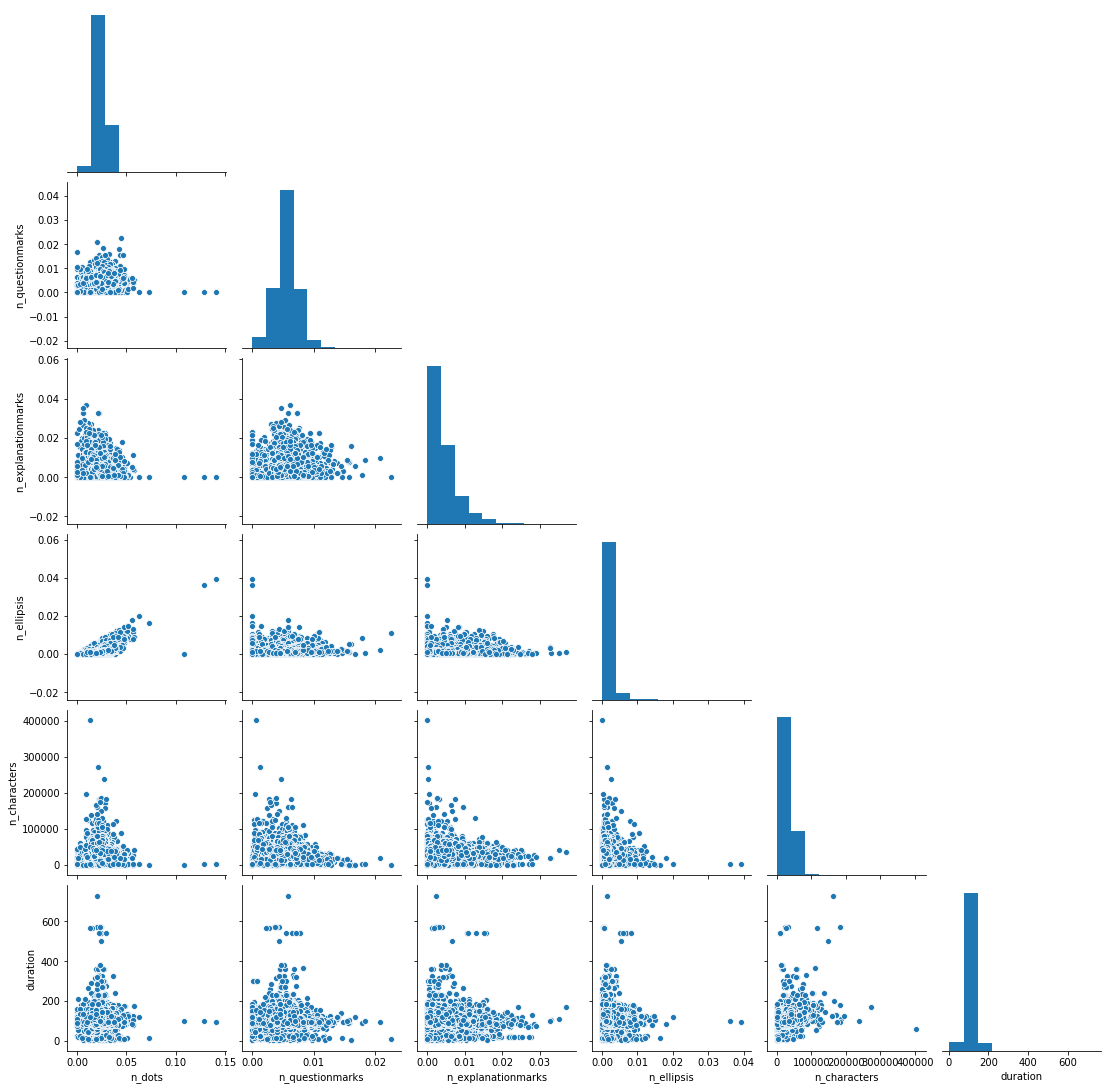

In [24]:
import seaborn as sns
grid = sns.pairplot(
    new_df[[
        'n_dots',
        'n_questionmarks',
        'n_explanationmarks',
        'n_ellipsis',
        'n_characters',
        'duration']], corner=True)

plt.show()

In [42]:
# sentence clustering
index = 18001
print(df.iloc[index])
t = df.text.iloc[index]

text                 Ich bin ein kleiner Junge , kleiner Junge , kl...
IMDB_ID                                                        3133722
genre                                                           Comedy
year                                                              2015
production_region                                              English
corpus                                                   untokenisiert
duration                                                            97
Name: 6789910.xml, dtype: object


In [43]:
import spacy

nlp = spacy.load('de_core_news_sm')
doc = nlp(t)

In [44]:
sents = [str(sent) for sent in doc.sents]

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words



tfidf = TfidfVectorizer(stop_words=get_stop_words('de'), max_features=6500)

X = tfidf.fit_transform(sents)

In [46]:
X

<2060x1807 sparse matrix of type '<class 'numpy.float64'>'
	with 4431 stored elements in Compressed Sparse Row format>

In [47]:
sents[np.argmax(np.sum(X, axis=1))]

'So zwischen der Tatsache , dass ich meine Mutter als Kind viel zu oft nackt sah , und der , dass mein Vater mir etwas vom Leben beibrachte , indem er mir seine alten Kondome in die Hand drückte - wie Trinkgeld für einen Pagen .'

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


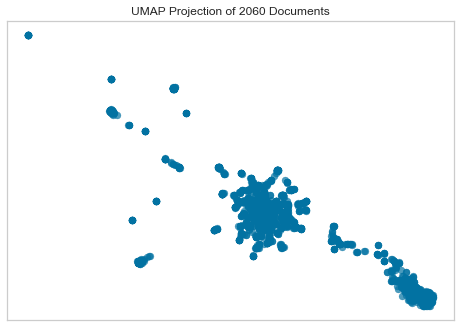

In [48]:
from yellowbrick.text import UMAPVisualizer

umap = UMAPVisualizer(metric='cosine')
umap.fit(X)
umap.show()

In [52]:
df.columns

Index(['text', 'IMDB_ID', 'genre', 'year', 'production_region', 'corpus',
       'duration'],
      dtype='object')

# Cluster two most common directors

In [123]:
df.groupby('directors')['text'].count().sort_values(ascending=False)

directors
nm0000095              34
nm0000142              31
nm0000033              30
nm0000229              28
nm0586281              28
                       ..
nm0771228               1
nm0771410               1
nm0771420,nm0222061     1
nm0771869               1
nm0582721               1
Name: text, Length: 5841, dtype: int64

In [124]:
# nm0000229 == Steven Spielberg
# nm0000631 == Ridley Scott
df2 = df[(df.directors == 'nm0000229') | (df.directors == 'nm0000631')]
df2.shape

(49, 10)

In [125]:
df2.head()

,text,IMDB_ID,genre,year,production_region,corpus,duration,directors,writers,main_genre
filename,,,,,,,,,,
3582426.xml,Besuchen Sie Mike Vernon Motors ! Die Adresse ...,67023,"Action,Thriller",1971.0,English,untokenisiert,90,nm0000229,nm0558577,Action
4924860.xml,Sugarland Express ( 1974 ) dTV - WDR - 3. Apri...,72226,"Crime,Drama",1974.0,English,untokenisiert,110,nm0000229,"nm0059493,nm0730422,nm0000229",Crime
104621.xml,"Komm schon , komm schon . GR0SSER ERÖFFNUNGSBA...",73195,"Adventure,Drama,Thriller",1975.0,English,untokenisiert,124,nm0000229,"nm0001940,nm0331956",Adventure
6575525.xml,"Sonora Wüste , Mexiko Heutiger Tag Sind wir di...",75860,"Drama,Sci-Fi",1977.0,"English, French, Spanish, Hindi",untokenisiert,137,nm0000229,"nm0000229,nm0059493,nm0069547,nm0384398,nm0730422",Drama
5851938.xml,DIE DUELLISTEN Der Duellist verlangt Genugtuun...,75968,"Drama,War",1977.0,"English, Russian",untokenisiert,100,nm0000631,"nm0891126,nm0175676",Drama


In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words

tfidf = TfidfVectorizer(stop_words=get_stop_words('de'), max_features=6500)

X = tfidf.fit_transform(df2.text)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


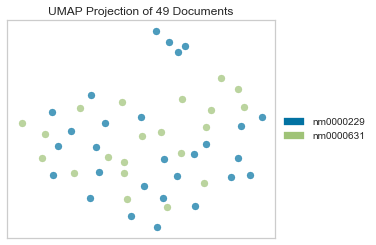

In [130]:
from yellowbrick.text import UMAPVisualizer

umap = UMAPVisualizer()
umap.fit(X, df2.directors)
umap.show()